## 0. Import some necessary modules

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

%matplotlib inline

## 1. Processing training dataset

### 1.1 Extract the training images and include them in different subdirectories based on labels

In [78]:
import io
import bson
import matplotlib.pyplot as plt
from skimage.data import imread
import multiprocessing as mp
from pprint import pprint
from keras.preprocessing import image
from PIL import Image
from itertools import islice
from keras.applications.xception import Xception, preprocess_input
from PIL import Image
import os

def processing(s):
    """Read images of different products from the train.bson in batches and save 
    them as JPEG files under different folders that correspond to their categorie"""
    data = bson.decode_file_iter(open('/home/jin/storage/train.bson', 'rb'))
    section = islice(data, s*1000000, (s+1)*1000000)
    for item in tqdm(section, total=1000000):
        _id = item['_id']
        category = item['category_id']
        if not os.path.exists('train/%s' % category):
            os.system('mkdir train/%s' % category)
        pics = item['imgs'] 
        for i in range(len(pics)):
            pic = pics[i]  
            img = Image.open(io.BytesIO(pic['picture']))
            img.save('train/%d/train_%d_%d.jpg' % (category, _id, i), 'JPEG')
        

In [5]:
n_batches = int(np.ceil(float(n_data)/1000000))
for i in range(0, n_batches):
    print("process %dth batch" % i)
    result = processing(i)

  0%|          | 17/1000000 [00:00<1:40:43, 165.48it/s]

process 0th batch


  0%|          | 0/1000000 [00:00<?, ?it/s]

process 1th batch


  0%|          | 0/1000000 [00:00<?, ?it/s]

process 2th batch


  0%|          | 0/1000000 [00:00<?, ?it/s]

process 3th batch


  0%|          | 0/1000000 [00:00<?, ?it/s]

process 4th batch


  0%|          | 0/1000000 [00:00<?, ?it/s]

process 5th batch


  0%|          | 0/1000000 [00:00<?, ?it/s]

process 6th batch


  0%|          | 0/1000000 [00:00<?, ?it/s]

process 7th batch


  7%|▋         | 69896/1000000 [04:06<54:37, 283.78it/s]  


### 1.2  Pair the list of file paths and the corresponding list of targets

In [2]:
from sklearn.datasets import load_files
from glob import glob
import numpy as np
category_folders = glob('train/*/')
sets = []

In [3]:
from tqdm import tqdm
categories = []
for i in tqdm(category_folders):
    category = i.split('/')[-2]
    categories.append(category)
    figs = glob(i+'*')
    targets = [category]*len(figs)
    pairs = [[x,y] for x, y in zip(figs, targets)]
    sets.append(pairs)

100%|██████████| 5270/5270 [00:47<00:00, 111.19it/s]


### 1.3 Calculate the number of figures contained in each category and make a statistic plot

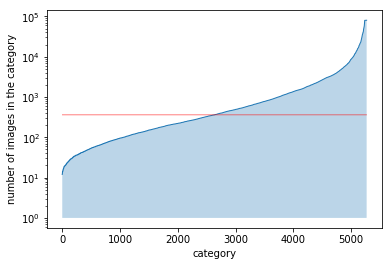

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

n_figs_category = [len(i) for i in sets]
n_figs_category_sorted = sorted(n_figs_category)
n_figs  = sum(n_figs_category)

fig, ax = plt.subplots()
x = range(1,5271)
y1 = [1]*5270
red_line =  [360]*5270
ax.plot(x, n_figs_category_sorted, lw = 1)
ax.plot(x, red_line, 'r', lw=0.5)
ax.set_yscale('log')
ax.fill_between(x,y1, n_figs_category_sorted, alpha=0.3)
plt.xlabel('category')
plt.ylabel('number of images in the category')
plt.savefig('figures/n_instances_category.png', dpi=300)

In [19]:
# Get some statistics about the number of images
# contained in different categories
df = pd.DataFrame({'data':n_figs_category})
df.describe()

,data
count,5270.000000
mean,2347.493928
std,8297.135538
min,12.000000
25%,129.000000
50%,362.000000
75%,1287.000000
max,80348.000000


### 1.4 Split the list of image file paths into training, test and validation data sets and save them as .pickle files

In [25]:
from random import shuffle
train = []
test = []
valid = []

n_train_category = 300 # Only include maximum 300 training exampels each category
n_test_category = 30 # The maximum number of test/vlidation samples for each category

train_old=0
test_old=0
valid_old =0

# The list of image paths for training, test, and validation set have the format:
# [[image_path_1, category_id_1],[image_path_2, category_id_2]...] 
for i in tqdm(sets):
    shuffle(i) # randomize the training, test and validation set
    if len(i) < (int(n_test_category/0.15)+1):
        seg = int(len(i)*0.15)
        train += i[:-seg*2]
        test += i[-seg*2: -seg]
        valid += i[-seg:]
    elif (int(n_test_category/0.15)+1) <= len(i) < n_test_category*2 + n_train_category:
        train += i[:-n_test_category*2]
        test += i[-n_test_category*2: -n_test_category]
        valid += i[-n_test_category:]
    else:
        train += i[:300]
        test += i[-n_test_category*2: -n_test_category]
        valid += i[-n_test_category:]



100%|██████████| 5270/5270 [00:05<00:00, 906.63it/s]


In [26]:
# Number of images in the train, test and valid set
print(len(train), len(test), len(valid))

1081356 128168 128168


In [27]:
from pickle import load, dump, HIGHEST_PROTOCOL

# Save the image paths for training, test and validation sets respectively
with open('datasets/train1.pickle', 'wb') as f:
    dump(train, f, HIGHEST_PROTOCOL)
with open('datasets/valid1.pickle', 'wb') as f:
    dump(valid, f, HIGHEST_PROTOCOL)
with open('datasets/test1.pickle', 'wb') as f:
    dump(test, f, HIGHEST_PROTOCOL)
with open('datasets/total1.pickle', 'wb') as f:
    dump(sets, f, HIGHEST_PROTOCOL)

In [32]:
import pandas as pd

# Replace the ID numbers of the 5270 different categories with integral indices from 0 to 5269
# according to their sequence in the file "category_names.csv"
category = list(pd.read_csv('category_names.csv')['category_id'])
train_i = []
test_i = []
valid_i = []
for item in train:
    x_ = item[0]
    y_ = category.index(int(item[1]))
    train_i.append([x_, y_])
shuffle(train_i)
for item in test:
    x_ = item[0]
    y_ = category.index(int(item[1]))
    test_i.append([x_, y_])
for item in valid:
    x_ = item[0]
    y_ = category.index(int(item[1]))
    valid_i.append([x_, y_])
    
# Save the image paths for training, test and validation sets with the replaced category indices
with open('datasets/train_i1.pickle', 'wb') as f:
    dump(train_i, f, HIGHEST_PROTOCOL)
with open('datasets/valid_i1.pickle', 'wb') as f:
    dump(valid_i, f, HIGHEST_PROTOCOL)
with open('datasets/test_i1.pickle', 'wb') as f:
    dump(test_i, f, HIGHEST_PROTOCOL)

## 2. Prepare the generator to feed the training/validation/test data

In [2]:
from keras.preprocessing import image  
import numpy as np


def path_to_tensor(img_path):
    """Load an image with the given path img_path in to a 224 x 224 x 3 numpy matrix"""
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """Load a series of N images with given paths contained in the list img_paths
    into a N x 224 x 224 x 3 numpy matrix"""
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

Using TensorFlow backend.
/home/jin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
from keras.applications.resnet50 import preprocess_input
def seg(x, y, batch_size):
    """Segment the list of training/test/validation file paths and their corresponding labels into sections according to the batch size"""
    X = []
    Y = []
    if len(x)%batch_size:
        steps = len(x)//batch_size+1
    else:
        steps = len(x)//batch_size
    for i in range(steps):
        if i != steps - 1:
            section_x = x[i*batch_size:(i+1)*batch_size]          
            section_y = y[i*batch_size:(i+1)*batch_size]               
        else:
            section_x = x[i*batch_size:] 
            section_y = y[i*batch_size:]
        X.append(section_x)
        Y.append(section_y)
        
    return X, Y
            
        
def feed_data(X, Y):
    """Yield a batch of pixel matrices of images as well as their corresponding category indices"""
    while 1:
        for files, labels in zip(X,Y):
            targets = []
            for i in labels:
                item = [0]*5270
                item[int(i)] = 1
                targets.append(item)
            # Rescale the pixel values in the matrices of images into the range from -1 to 1
            features = preprocess_input(paths_to_tensor(files))
            yield features, np.array(targets)
    

In [4]:
from pickle import load

import pandas as pd

with open('datasets/train_i1.pickle', 'rb') as f:
    train_set = np.array(load(f))
with open('datasets/valid_i1.pickle', 'rb') as f:
    valid_set = np.array(load(f))
with open('datasets/test_i1.pickle', 'rb') as f:
    test_set = np.array(load(f))

batch_size = 25

# Calculate the number of batches for the training set  
if len(train_set)%batch_size:
    steps_train = len(train_set)//batch_size+1
else:
    steps_train = len(train_set)//batch_size

# Calculate the number of batches for the validation set  
if len(valid_set)%batch_size:
    steps_valid = len(valid_set)//batch_size+1
else:
    steps_valid = len(valid_set)//batch_size
    
# Calculate the number of batches for the test set  
if len(test_set)%batch_size:
    steps_valid = len(test_set)//batch_size+1
else:
    steps_valid = len(test_set)//batch_size
    
# Segment the list of training/test/validation file paths 
# and their corresponding labels into sections according to the batch size
X_train,Y_train = seg(train_set[:,0], train_set[:,1], batch_size)
X_valid, Y_valid = seg(valid_set[:,0], valid_set[:,1], batch_size)
X_test, Y_test = seg(test_set[:,0], test_set[:,1], batch_size)

# Prepare the generator 
train_gen = feed_data(X_train, Y_train)
valid_gen = feed_data(X_valid, Y_valid)
test_gen = feed_data(X_test, Y_test)

## 3. Benchmark model
### 3.1 Build the model with a vanilla CNN

In [5]:
from keras.models import Model, Sequential
from keras.layers import Conv2D, Dense, Dropout,MaxPooling2D, GlobalAveragePooling2D

model_vanilla = Sequential()
model_vanilla.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
model_vanilla.add(MaxPooling2D(pool_size=3))
model_vanilla.add(Conv2D(filters=1024, kernel_size=3, padding='same', activation='relu'))
model_vanilla.add(MaxPooling2D(pool_size=3))
model_vanilla.add(Conv2D(filters=2048, kernel_size=3, padding='same', activation='relu'))
model_vanilla.add(MaxPooling2D(pool_size=3))
model_vanilla.add(GlobalAveragePooling2D())
model_vanilla.add(Dropout(0.4))
model_vanilla.add(Dense(5270, activation='softmax'))
model_vanilla.load_weights("weights/weights.best.vanilla1.hdf5")
model_vanilla.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 512)     14336     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 1024)      4719616   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 1024)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 2048)      18876416  
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 2048)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
__________

In [33]:
from keras.callbacks import ModelCheckpoint

model_vanilla.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
check_pointer = ModelCheckpoint(filepath="weights/weights.best.vanilla1.hdf5", verbose=1, save_best_only=True)

In [34]:
model_vanilla.fit_generator(train_gen, steps_per_epoch=steps_train, epochs=8, callbacks=[check_pointer], verbose=1, validation_data=valid_gen, validation_steps=steps_valid)

Epoch 1/8
135170/135170 [==============================] - 42759s 316ms/step - loss: 16.1140 - acc: 2.5708e-04 - val_loss: 16.1143 - val_acc: 2.3407e-04
Epoch 2/8
135170/135170 [==============================] - 42684s 316ms/step - loss: 16.1140 - acc: 2.5708e-04 - val_loss: 16.1143 - val_acc: 2.3407e-04
Epoch 3/8
135170/135170 [==============================] - 42953s 318ms/step - loss: 16.1140 - acc: 2.5708e-04 - val_loss: 16.1143 - val_acc: 2.3407e-04
Epoch 4/8
 18778/135170 [===>..........................] - ETA: 9:55:17 - loss: 16.1151 - acc: 1.8639e-04

KeyboardInterrupt: 

### 3.2 Test the model performance on the test set

In [6]:
features, labels = test_set[:,0], test_set[:,1]
labels= labels.astype('int')

def predict(paths, batch_size=256):
    n_batches = int(np.ceil(len(paths)/batch_size))
    predictions = []
    for n in tqdm(range(n_batches)):
        if n != n_batches-1:
            paths_n = paths[n*batch_size:(n+1)*batch_size]
        else:
            paths_n = paths[n*batch_size:]
        X = paths_to_tensor(paths_n)
        predictions += list(np.argmax(model_vanilla.predict(preprocess_input(X)), axis=1))
    return np.array(predictions)

In [7]:
predictions =predict(features, batch_size=1000)
print('accuracy: ', sum(predictions == labels)/len(labels))

100%|██████████| 129/129 [21:11<00:00,  9.86s/it]

accuracy:  0.000234067786031


## 4. My solution (stage I) - only train the last fully connected layer of pre-trained ResNet50 model
### 4.1 Use transfer learning technique to train the model

In [55]:
#from keras.applications.xception import Xception, preprocess_input
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout,GlobalAveragePooling2D

# Remove the last FC layer of ResNet50 with pretrained weights and add a new FC layer
base_model = ResNet50(weights='imagenet')

x = base_model.layers[-2].output
output = Dense(5270, activation='softmax')(x)
model = Model(input=base_model.input, output=output)

# Only train the weights of the new FC layer
for layer in base_model.layers:
        layer.trainable=False

model.summary()




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_6[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_246 (Activation)     (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

/home/jin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [ ]:
from keras.callbacks import ModelCheckpoint
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

check_pointer = ModelCheckpoint(filepath='weights/weights.best.hdf5', verbose=1, save_best_only=True)

model.fit_generator(train_gen, steps_per_epoch=steps_train, epochs=8, verbose=1,
                             callbacks=[check_pointer], validation_data=valid_gen, validation_steps=steps_valid)

### 4.2 Test the model performance on the test set

In [16]:
features, labels = test_set[:,0], test_set[:,1]
labels= labels.astype('int')

def predict(paths, batch_size=256):
    n_batches = int(np.ceil(len(paths)/batch_size))
    predictions = []
    for n in tqdm(range(n_batches)):
        if n != n_batches-1:
            paths_n = paths[n*batch_size:(n+1)*batch_size]
        else:
            paths_n = paths[n*batch_size:]
        X = paths_to_tensor(paths_n)
        predictions += list(np.argmax(model.predict(preprocess_input(X)), axis=1))
    return np.array(predictions)
 

In [57]:
predictions =predict(features, batch_size=1000)
print('accuracy: ', sum(predictions == labels)/len(labels))

100%|██████████| 129/129 [14:01<00:00,  6.52s/it]


accuracy:  0.36445134511


## 5 My solution (stage I) - fine tunning of the previous model
### 5.1 Fine tune the weights of the entire ResNet50 model based on the previous training step

#### 5.1a  Fine tune the learning rate of the Adam optimizer

In [5]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout,GlobalAveragePooling2D
from keras.optimizers import Adam

def create_model(lr=0.01):
    base_model = ResNet50(weights='imagenet') 
    x = base_model.layers[-2].output
    prediction = Dense(5270, activation='softmax')(x)
    model_fine = Model(input=base_model.input, output=prediction)
    model_fine.load_weights("weights/weights.best7.hdf5")
    optimizer = Adam(lr=lr)
    model_fine.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model_fine

param_grid = dict(lr=[0.00001, 0.000033, 0.0001, 0.00033, 0.001])

In [6]:
# The hyper-parameter tunning will be performed on the first 1/20 of the training set
X = []
Y = []
steps_tune = int(steps_train/20)
for i in tqdm(range(steps_tune)):
    x, y = next(train_gen)
    X.append(x)
    Y.append(y)
X = np.vstack(X)
Y = np.concatenate(Y)

100%|██████████| 2162/2162 [01:33<00:00, 23.07it/s]


In [8]:
model = KerasClassifier(build_fn=create_model, epochs=4, batch_size=15, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [9]:
grid_result = grid.fit(X,Y)

/home/jin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


Epoch 1/4
36033/36033 [==============================] - 706s 20ms/step - loss: 2.6189 - acc: 0.4645
Epoch 2/4
36033/36033 [==============================] - 573s 16ms/step - loss: 1.5990 - acc: 0.6424
Epoch 3/4
36033/36033 [==============================] - 571s 16ms/step - loss: 1.0124 - acc: 0.7739
Epoch 4/4
36033/36033 [==============================] - 251s 7ms/step
Epoch 1/4
36033/36033 [==============================] - 666s 18ms/step - loss: 2.5549 - acc: 0.4709
Epoch 2/4
36033/36033 [==============================] - 544s 15ms/step - loss: 1.5556 - acc: 0.6541
Epoch 3/4
36033/36033 [==============================] - 543s 15ms/step - loss: 1.0004 - acc: 0.7732
Epoch 4/4
36033/36033 [==============================] - 242s 7ms/step
Epoch 1/4
36034/36034 [==============================] - 669s 19ms/step - loss: 2.5425 - acc: 0.4707
Epoch 2/4
36034/36034 [==============================] - 545s 15ms/step - loss: 1.5340 - acc: 0.6527
Epoch 3/4
36034/36034 [===========================

ResourceExhaustedError: OOM when allocating tensor with shape[15,7,7,512]
	 [[Node: res5c_branch2a_10/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_536/Relu, res5c_branch2a_10/kernel/read)]]
	 [[Node: metrics_10/acc/Mean/_54915 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_25015_metrics_10/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'res5c_branch2a_10/convolution', defined at:
  File "/home/jin/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jin/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jin/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jin/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/jin/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jin/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/jin/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-61170a4ec618>", line 1, in <module>
    grid_result = grid.fit(X,Y)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py", line 639, in fit
    cv.split(X, y, groups)))
  File "/home/jin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/home/jin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/home/jin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/home/jin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/home/jin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 458, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py", line 203, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/keras/wrappers/scikit_learn.py", line 136, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
  File "<ipython-input-5-7dacd94787a6>", line 9, in create_model
    base_model = ResNet50(weights='imagenet')
  File "/home/jin/anaconda3/lib/python3.6/site-packages/keras/applications/resnet50.py", line 230, in ResNet50
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
  File "/home/jin/anaconda3/lib/python3.6/site-packages/keras/applications/resnet50.py", line 61, in identity_block
    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/keras/layers/convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 3189, in conv2d
    data_format=tf_data_format)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 751, in convolution
    return op(input, filter)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 835, in __call__
    return self.conv_op(inp, filter)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 499, in __call__
    return self.call(inp, filter)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 187, in __call__
    name=self.name)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 631, in conv2d
    data_format=data_format, name=name)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/jin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[15,7,7,512]
	 [[Node: res5c_branch2a_10/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_536/Relu, res5c_branch2a_10/kernel/read)]]
	 [[Node: metrics_10/acc/Mean/_54915 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_25015_metrics_10/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


#### 5.1b  Use the optimal learning rate to fine tune the weights of the entire ResNet50 model

In [1]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout,GlobalAveragePooling2D



base_model = ResNet50(weights='imagenet') 

x = base_model.layers[-2].output
prediction = Dense(5270, activation='softmax')(x)
model_fine = Model(input=base_model.input, output=prediction)

# Load the weights of the model trained in the previous step
model_fine.load_weights("weights/weights.best7.hdf5")
model_fine.summary()



Using TensorFlow backend.
/home/jin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/jin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [62]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# Train with a much lower learning rate
optimizer = Adam(lr=0.0001)
model_fine.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

check_pointer = ModelCheckpoint(filepath='weights/weights.best.fine1.hdf5', verbose=1, save_best_only=True)




In [65]:
model_fine.fit_generator(train_gen, steps_per_epoch=steps_train, epochs=4, verbose=1,
                             callbacks=[check_pointer], validation_data=valid_gen, validation_steps=steps_valid)



Epoch 1/4
27034/27034 [==============================] - 14901s 551ms/step - loss: 4.2222 - acc: 0.2686 - val_loss: 3.9324 - val_acc: 0.3546
Epoch 2/4
27034/27034 [==============================] - 14887s 551ms/step - loss: 3.3939 - acc: 0.3758 - val_loss: 3.7242 - val_acc: 0.3855
Epoch 3/4
27034/27034 [==============================] - 14991s 555ms/step - loss: 2.9461 - acc: 0.4381 - val_loss: 3.5826 - val_acc: 0.4066
Epoch 4/4
27034/27034 [==============================] - 15035s 556ms/step - loss: 2.6228 - acc: 0.4849 - val_loss: 3.5729 - val_acc: 0.4106


In [71]:
model_fine.save('weights/fullmodel.best.fine1.hdf5')

In [72]:
check_pointer = ModelCheckpoint(filepath='weights/weights.best.fine2.hdf5', verbose=1, save_best_only=True)
model_fine.fit_generator(train_gen, steps_per_epoch=steps_train, epochs=4, verbose=1,
                             callbacks=[check_pointer], validation_data=valid_gen, validation_steps=steps_valid)

Epoch 1/4
27034/27034 [==============================] - 15044s 556ms/step - loss: 2.3608 - acc: 0.5234 - val_loss: 3.4789 - val_acc: 0.4279
Epoch 2/4
27034/27034 [==============================] - 15053s 557ms/step - loss: 2.1388 - acc: 0.5569 - val_loss: 3.4796 - val_acc: 0.4341
Epoch 3/4
27034/27034 [==============================] - 15094s 558ms/step - loss: 1.9498 - acc: 0.5871 - val_loss: 3.5375 - val_acc: 0.4352
Epoch 4/4
27034/27034 [==============================] - 15109s 559ms/step - loss: 1.7861 - acc: 0.6122 - val_loss: 3.4805 - val_acc: 0.4440


### 5.2 Test the performance of the fine-tuned model on the test set

In [2]:
from keras.models import load_model
model_fine = load_model('weights/fullmodel.best.fine3.hdf5')

Using TensorFlow backend.
/home/jin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [7]:
features, labels = test_set[:,0], test_set[:,1]
labels= labels.astype('int')

def predict(paths, batch_size=256):
    n_batches = int(np.ceil(len(paths)/batch_size))
    predictions = []
    for n in tqdm(range(n_batches)):
        if n != n_batches-1:
            paths_n = paths[n*batch_size:(n+1)*batch_size]
        else:
            paths_n = paths[n*batch_size:]
        X = paths_to_tensor(paths_n)
        predictions += list(np.argmax(model_fine.predict(preprocess_input(X)), axis=1))
    return np.array(predictions)

In [8]:
predictions =predict(features, batch_size=1000)
print('accuracy: ', sum(predictions == labels)/len(labels))

100%|██████████| 129/129 [14:02<00:00,  6.53s/it]


accuracy:  0.449371137882


### 5.3 Save the model

In [ ]:
model_fine.save('weights/fullmodel.best.fine3.hdf5')

## 6. Calculate the bottleneck features using the fine tuned model of the last step
### 6.1 Set up the model (model_bnf) to output the predicted category and the bottleneck features before the last fully-connected layer

In [1]:
from keras.models import load_model, Model

model = load_model('weights/fullmodel.best.fine3.hdf5')
output = [model.layers[-2].output, model.output]
model_bnf = Model(input=model.input, output=output)

Using TensorFlow backend.
/home/jin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### 6.2 Calculate the bottleneck features for all the images of the training set and save them in a sorted state according to their categories

In [94]:
# The bottleneck features are put into a dictionary, where the keys are the indices of categories,
# and the corresponding values are lists of bottleneck features from images with the same label.
train_sorted = {}  
predictions = [] # record the prediction of the model for each training image
for n in tqdm(range(steps_train)):
    features, labels = next(train_gen)
    bnfeatures = model_bnf.predict(features)
    labels_n = [list(i).index(1) for i in labels]
    predictions += labels_n
    for bnf, label in zip(bnfeatures, labels_n):
        keys = train_sorted.keys()
        if label not in keys:
            train_sorted[label] = []
        train_sorted[label].append(bnf)

100%|██████████| 1082/1082 [2:09:04<00:00,  7.16s/it] 


In [95]:
from pickle import load, dump, HIGHEST_PROTOCOL

# Save the calculated bottleneck features and the predicted categories for the training set
with open('bnfeature/train_fine3.pickle', 'wb') as f:
    dump(train_sorted, f, HIGHEST_PROTOCOL)
with open('prediction/fine3_train.pickle', 'wb') as f:
    dump(predictions, f, HIGHEST_PROTOCOL)

### 6.3 Calculate the bottleneck features for all the images of the valid set and save them in a sorted state according to their categories

In [ ]:
valid_sorted = {}  
predictions = [] 
for n in tqdm(range(steps_valid)):
    features, labels = next(valid_gen)
    bnfeatures = model_bnf.predict(features)
    labels_n = [list(i).index(1) for i in labels]
    predictions += labels_n
    for bnf, label in zip(bnfeatures, labels_n):
        keys = valid_sorted.keys()
        if label not in keys:
            valid_sorted[label] = []
        valid_sorted[label].append(bnf)

In [10]:
from pickle import load, dump, HIGHEST_PROTOCOL
with open('bnfeature/valid3_fine.pickle', 'wb') as f:
    dump(valid_sorted, f, HIGHEST_PROTOCOL)
with open('prediction/fine3_valid.pickle', 'wb') as f:
    dump(predictions, f, HIGHEST_PROTOCOL)